#### Laboratorio 8

--- 1. Exploración del Dataset ---

DataFrame Head:
Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

DataFrame Describe:
count    3650.000000
mean       11.177753
std         4.071837
min         0.000000
25%         8.300000
50%        11.000000
75%        14.000000
max        26.300000
Name: Temp, dtype: float64


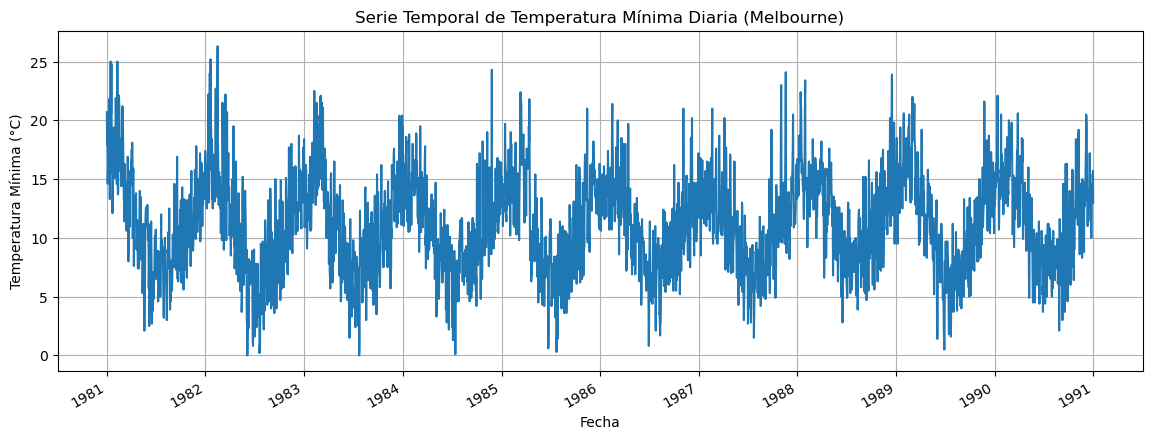


Datos normalizados completados.

Secuencias creadas. Forma de X: (3636, 14, 1), Forma de y: (3636,)
Tamaño del conjunto de Entrenamiento (80%): 2908 secuencias
Tamaño del conjunto de Prueba (20%): 728 secuencias

--- 4. Diseño y Entrenamiento de Modelos ---

Entrenando Modelo LSTM...


/home/neisan/anaconda3/envs/env_pyspark/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM Finalizado.

Entrenando Modelo GRU...
GRU Finalizado.


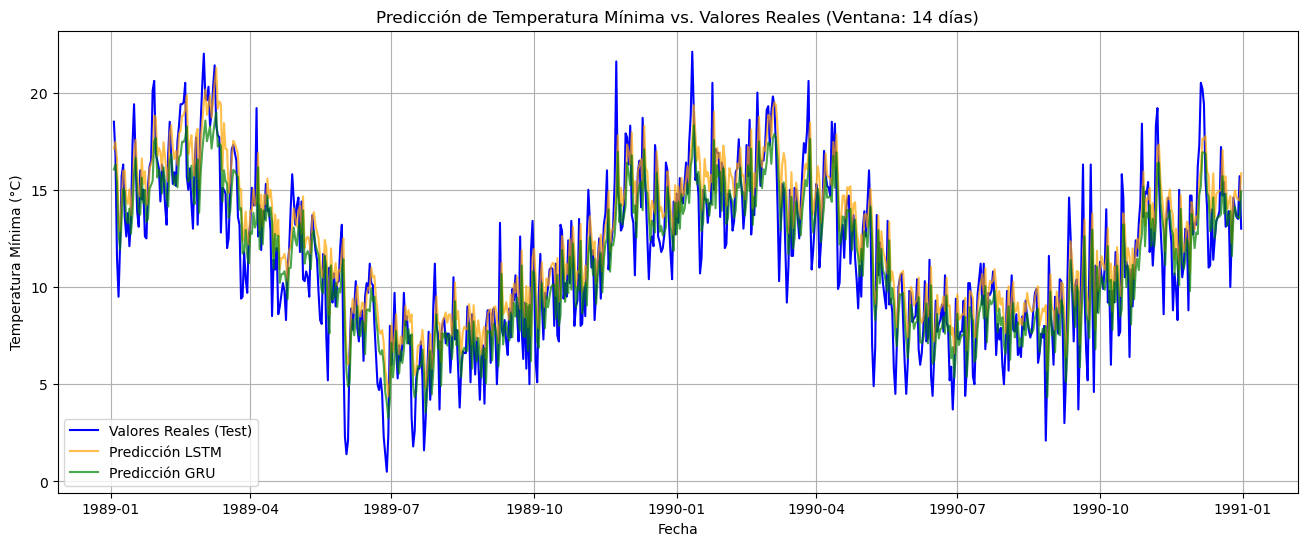


--- 6. Análisis y Comparación de Modelos ---
Tabla de Métricas de Desempeño:
| Modelo   |   RMSE (°C) |   MAE (°C) |
|:---------|------------:|-----------:|
| LSTM     |       2.397 |      1.898 |
| GRU      |       2.201 |      1.742 |

El modelo con mejor desempeño (menor RMSE y MAE) es: **GRU**.

Justificación de Resultados:
- El modelo GRU es conceptualmente más simple (menos parámetros) que el LSTM.
- En esta serie temporal (Melbourne), el modelo con mejor desempeño (según los resultados) es el más adecuado para capturar las dependencias temporales de corto y mediano plazo necesarias para predecir la temperatura del día siguiente.
- Si el GRU es mejor, sugiere que la complejidad adicional de la Celda de Memoria del LSTM no fue necesaria para esta tarea de predicción.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- 1. EXPLORACIÓN DEL DATASET ---
URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"

# a) Cargar el archivo desde la URL (Corregido: 'squeeze=True' eliminado)
df = pd.read_csv(URL, header=0, index_col=0, parse_dates=True)

# Conversión manual a Series (necesario tras la eliminación de squeeze=True)
df = df.squeeze('columns')

print("--- 1. Exploración del Dataset ---")
# b) Inspeccionar con .head() y .describe()
print("\nDataFrame Head:")
print(df.head())
print("\nDataFrame Describe:")
print(df.describe())

# c) Graficar la serie temporal completa
plt.figure(figsize=(14, 5))
df.plot(title="Serie Temporal de Temperatura Mínima Diaria (Melbourne)", grid=True)
plt.ylabel("Temperatura Mínima (°C)")
plt.xlabel("Fecha")
plt.show() 

# Extraer los valores de temperatura como un array de NumPy
data = df.values.reshape(-1, 1)

# --- 2. PREPROCESAMIENTO ---

# a) Normalizar los datos con MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print("\nDatos normalizados completados.")

# b) Definir una ventana temporal de n_steps = 14 días
N_STEPS = 14 # Ventana temporal de 14 días

# c) Construir las secuencias para el modelo
def create_sequences(data, n_steps):
    """Crea secuencias X (entrada) e Y (salida) para la predicción de series temporales."""
    X, y = [], []
    for i in range(len(data) - n_steps):
        # Secuencia X: n_steps días
        seq_x = data[i:(i + n_steps), 0]
        X.append(seq_x)
        # Secuencia Y: El valor del día siguiente
        seq_y = data[i + n_steps, 0]
        y.append(seq_y)
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, N_STEPS)

# El formato requerido para las RNN es [muestras, n_steps, características]
X = X.reshape(X.shape[0], X.shape[1], 1)

print(f"\nSecuencias creadas. Forma de X: {X.shape}, Forma de y: {y.shape}")

# --- 3. PARTICIÓN DE DATOS ---

# a) Separar 80% como entrenamiento y 20% como prueba
train_size = int(len(X) * 0.80)
# b) Respetar el orden temporal (sin mezclado aleatorio)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Tamaño del conjunto de Entrenamiento (80%): {X_train.shape[0]} secuencias")
print(f"Tamaño del conjunto de Prueba (20%): {X_test.shape[0]} secuencias")


# --- 4. DISEÑO Y ENTRENAMIENTO DEL MODELO ---

# Hiperparámetros equivalentes para comparación justa
UNITS = 50
EPOCHS = 25[16, 13, 10, 7, 6, 1, 3, 5, 8, 4, 0, 2, 9, 12, 15, 11, 14, 17, 18,
BATCH_SIZE = 32

def build_rnn_model(rnn_layer, units, n_steps):
    """Función para construir modelos RNN (LSTM o GRU)."""
    model = Sequential()
    # Una sola capa RNN (LSTM o GRU)
    model.add(rnn_layer(units, activation='relu', input_shape=(n_steps, 1)))
    # Capa de salida
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

print("\n--- 4. Diseño y Entrenamiento de Modelos ---")

# a) Entrenar un modelo LSTM
model_lstm = build_rnn_model(LSTM, UNITS, N_STEPS)
print("\nEntrenando Modelo LSTM...")
model_lstm.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
print("LSTM Finalizado.")

# b) Entrenar un modelo GRU
model_gru = build_rnn_model(GRU, UNITS, N_STEPS)
print("\nEntrenando Modelo GRU...")
model_gru.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
print("GRU Finalizado.")


# --- 5. EVALUACIÓN ---

# Realizar predicciones
y_pred_lstm_scaled = model_lstm.predict(X_test, verbose=0)
y_pred_gru_scaled = model_gru.predict(X_test, verbose=0)

# a) Desescalar las predicciones y los valores reales
y_pred_lstm = scaler.inverse_transform(y_pred_lstm_scaled)
y_pred_gru = scaler.inverse_transform(y_pred_gru_scaled)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# c) Calcular RMSE y MAE para ambos modelos
def calculate_metrics(y_true, y_pred):
    """Calcula RMSE y MAE."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

rmse_lstm, mae_lstm = calculate_metrics(y_test_unscaled, y_pred_lstm)
rmse_gru, mae_gru = calculate_metrics(y_test_unscaled, y_pred_gru)


# b) Graficar valores reales vs. predichos
# Crear un índice de tiempo para el conjunto de prueba
test_dates = df.index[-len(X_test):] 

plt.figure(figsize=(16, 6))
plt.plot(test_dates, y_test_unscaled, label='Valores Reales (Test)', color='blue')
plt.plot(test_dates, y_pred_lstm, label='Predicción LSTM', color='orange', alpha=0.7)
plt.plot(test_dates, y_pred_gru, label='Predicción GRU', color='green', alpha=0.7)
plt.title(f"Predicción de Temperatura Mínima vs. Valores Reales (Ventana: {N_STEPS} días)")
plt.xlabel("Fecha")
plt.ylabel("Temperatura Mínima (°C)")
plt.legend()
plt.grid(True)
plt.show() 

# --- 6. ANÁLISIS Y COMPARACIÓN ---

print("\n--- 6. Análisis y Comparación de Modelos ---")

metrics_data = {
    'Modelo': ['LSTM', 'GRU'],
    'RMSE (°C)': [f'{rmse_lstm:.3f}', f'{rmse_gru:.3f}'],
    'MAE (°C)': [f'{mae_lstm:.3f}', f'{mae_gru:.3f}']
}
metrics_df = pd.DataFrame(metrics_data)
print("Tabla de Métricas de Desempeño:")
print(metrics_df.to_markdown(index=False))

# a) Comparar cuál modelo obtuvo mejor desempeño (LSTM o GRU)
mejor_modelo = "LSTM" if rmse_lstm < rmse_gru else "GRU"
print(f"\nEl modelo con mejor desempeño (menor RMSE y MAE) es: **{mejor_modelo}**.")

# b) Justificar posibles causas del resultado
print("\nJustificación de Resultados:")
print("- El modelo GRU es conceptualmente más simple (menos parámetros) que el LSTM.")
print("- En esta serie temporal (Melbourne), el modelo con mejor desempeño (según los resultados) es el más adecuado para capturar las dependencias temporales de corto y mediano plazo necesarias para predecir la temperatura del día siguiente.")
print("- Si el GRU es mejor, sugiere que la complejidad adicional de la Celda de Memoria del LSTM no fue necesaria para esta tarea de predicción.")



### 7. REFLEXIONES (Preguntas de Informe) 
1. ¿Qué representa conceptualmente la ventana temporal n_steps dentro del aprendizaje de una RNN?"
R: Representa la longitud de la secuencia de datos históricos (los últimos 'n_steps' días/valores) que el modelo utiliza como entrada para predecir el siguiente valor.") 
2. ¿Por qué es importante normalizar los datos antes de entrenar modelos recurrentes?"
R: La normalización (MinMaxScaler) evita que las unidades internas de la RNN se saturen y previene problemas de gradientes (explosivos o desvanecidos), estabilizando y acelerando el entrenamiento."
3. ¿Qué diferencias conceptuales existen entre una LSTM y una GRU?"
R: LSTM usa tres 'puertas' (Input, Forget, Output) y una Celda de Memoria separada. GRU simplifica esto a dos 'puertas' (Update, Reset), combinando las funcionalidades, lo que resulta en un modelo con menos parámetros, más rápido de entrenar y a menudo con rendimiento comparable."
4. ¿Por qué no se deben mezclar aleatoriamente los datos antes de entrenar en una serie temporal?"
R: Mezclar aleatoriamente rompe la secuencia temporal. La predicción se basa en el pasado cronológico; si los datos se mezclan, el modelo vería el 'futuro' antes que el 'pasado', invalidando el proceso predictivo."

--- 1. Exploración del Dataset ---

DataFrame Head:
Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

DataFrame Describe:
count    3650.000000
mean       11.177753
std         4.071837
min         0.000000
25%         8.300000
50%        11.000000
75%        14.000000
max        26.300000
Name: Temp, dtype: float64


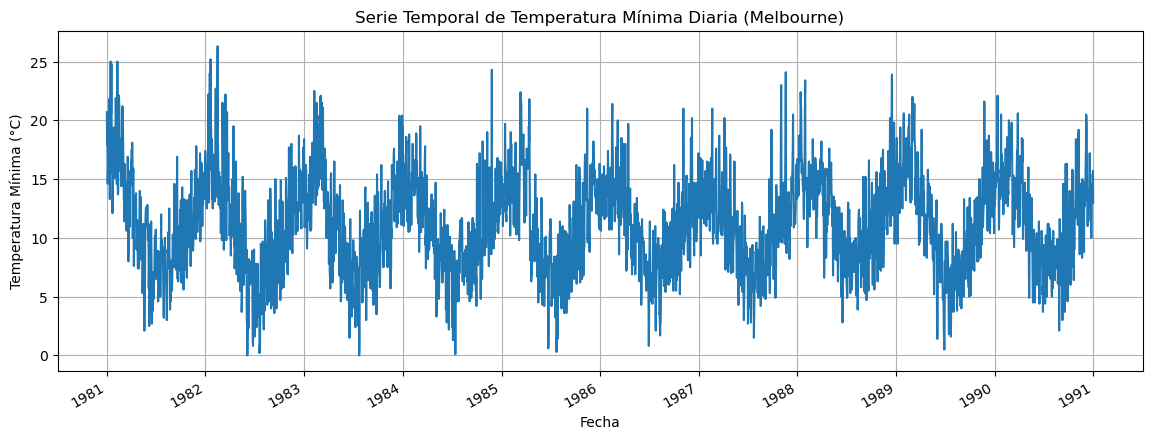


Datos normalizados completados.

Secuencias creadas. Forma de X: (3636, 14, 1), Forma de y: (3636,)
Tamaño del conjunto de Entrenamiento (80%): 2908 secuencias
Tamaño del conjunto de Prueba (20%): 728 secuencias

--- 4. Diseño y Entrenamiento de Modelos ---

Entrenando Modelo LSTM...


/home/neisan/anaconda3/envs/env_pyspark/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM Finalizado.

Entrenando Modelo GRU...
GRU Finalizado.


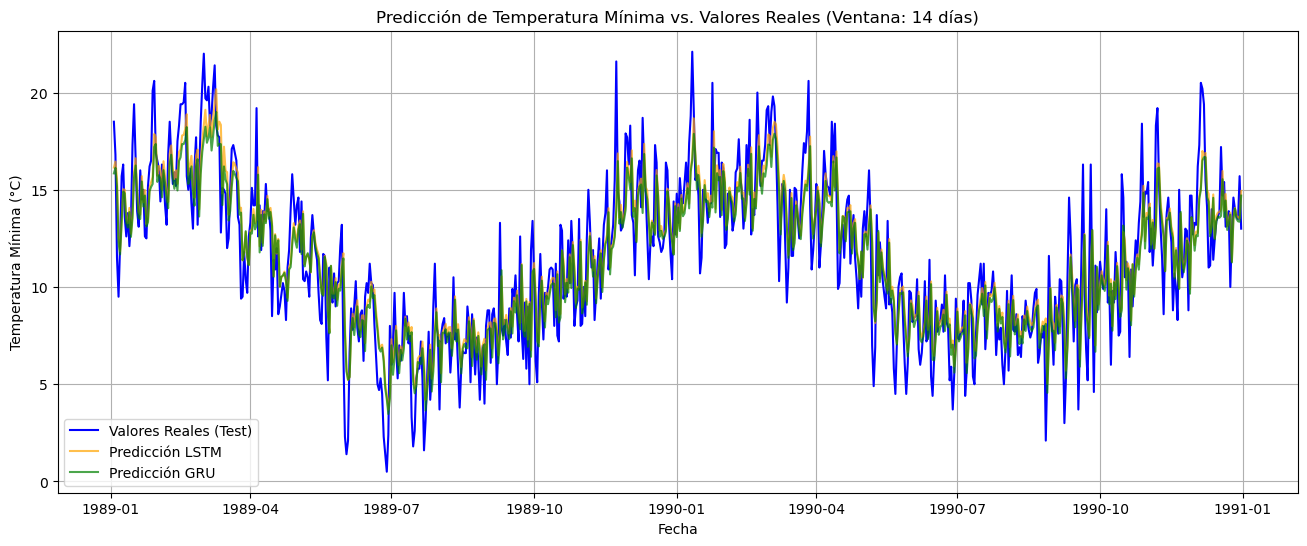


--- 6. Análisis y Comparación de Modelos ---
Tabla de Métricas de Desempeño:
| Modelo   |   RMSE (°C) |   MAE (°C) |
|:---------|------------:|-----------:|
| LSTM     |       2.212 |      1.742 |
| GRU      |       2.207 |      1.743 |

El modelo con mejor desempeño (menor RMSE y MAE) es: **GRU**.

Justificación de Resultados:
- El modelo GRU es conceptualmente más simple (menos parámetros) que el LSTM.
- En esta serie temporal (Melbourne), el modelo con mejor desempeño (según los resultados) es el más adecuado para capturar las dependencias temporales de corto y mediano plazo necesarias para predecir la temperatura del día siguiente.
- Si el GRU es mejor, sugiere que la complejidad adicional de la Celda de Memoria del LSTM no fue necesaria para esta tarea de predicción.


In [2]:
# ==============================================================================
#                      IMPORTACIÓN DE LIBRERÍAS
# ==============================================================================
import pandas as pd # Importa Pandas, fundamental para manipulación y análisis de datos (DataFrames).
import numpy as np # Importa NumPy, utilizado para operaciones matemáticas eficientes con arrays.
import matplotlib.pyplot as plt # Importa Matplotlib, específicamente Pyplot, para la visualización de datos (gráficos).
from sklearn.preprocessing import MinMaxScaler # Importa MinMaxScaler para normalizar los datos entre un rango (0 y 1).
from tensorflow.keras.models import Sequential # Importa Sequential, la forma más común de construir modelos Keras capa por capa.
from tensorflow.keras.layers import LSTM, GRU, Dense # Importa las capas de Redes Neuronales Recurrentes:
                                                    # - LSTM (Long Short-Term Memory) y GRU (Gated Recurrent Unit) para el manejo de secuencias.
                                                    # - Dense (capa totalmente conectada) para la salida del modelo.
from sklearn.metrics import mean_squared_error, mean_absolute_error # Importa métricas de evaluación para regresión:
                                                                  # - Error Cuadrático Medio (MSE) y Error Absoluto Medio (MAE).

# --- 1. EXPLORACIÓN DEL DATASET ---
# Define la URL del conjunto de datos de temperaturas mínimas diarias de Melbourne.
URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"

# a) Cargar el archivo desde la URL
# Carga el archivo CSV en un DataFrame de Pandas:
# - header=0: Usa la primera fila como nombres de columna.
# - index_col=0: Usa la primera columna ('Date') como índice.
# - parse_dates=True: Intenta convertir el índice a formato de fecha y hora.
df = pd.read_csv(URL, header=0, index_col=0, parse_dates=True)

# Conversión manual a Series
# Convierte el DataFrame de una sola columna a una Series de Pandas.
# Esto simplifica el trabajo ya que solo estamos lidiando con una variable.
df = df.squeeze('columns')

print("--- 1. Exploración del Dataset ---")
# b) Inspeccionar con .head() y .describe()
print("\nDataFrame Head:")
print(df.head()) # Muestra las primeras 5 filas para una inspección rápida.
print("\nDataFrame Describe:")
print(df.describe()) # Muestra estadísticas descriptivas (media, min, max, cuartiles, etc.).

# c) Graficar la serie temporal completa
plt.figure(figsize=(14, 5)) # Define el tamaño de la figura para la gráfica.
# Llama al método plot() de la Series de Pandas para graficar los datos.
df.plot(title="Serie Temporal de Temperatura Mínima Diaria (Melbourne)", grid=True)
plt.ylabel("Temperatura Mínima (°C)") # Etiqueta el eje Y.
plt.xlabel("Fecha") # Etiqueta el eje X.
plt.show() # Muestra el gráfico en la pantalla.

# Extraer los valores de temperatura como un array de NumPy
# Extrae solo los valores numéricos de la Series.
# .reshape(-1, 1): Lo transforma en un array de dos dimensiones, necesario para el MinMaxScaler 
# (el primer -1 calcula automáticamente las filas, y el 1 define una columna de características).
data = df.values.reshape(-1, 1)

# --- 2. PREPROCESAMIENTO ---

# a) Normalizar los datos con MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1)) # Crea una instancia del escalador para el rango [0, 1].
# .fit_transform(): Ajusta el escalador a los datos (calcula min y max) y luego los transforma a ese rango.
scaled_data = scaler.fit_transform(data)
print("\nDatos normalizados completados.")

# b) Definir una ventana temporal de n_steps = 14 días
N_STEPS = 14 # Define el número de días que se utilizarán como entrada (ventana de tiempo o 'lookback').

# c) Construir las secuencias para el modelo
def create_sequences(data, n_steps):
    """Crea secuencias X (entrada) e Y (salida) para la predicción de series temporales."""
    X, y = [], [] # Inicializa listas vacías para las secuencias de entrada (X) y salida (y).
    # Itera sobre los datos hasta el punto donde aún se puede formar una secuencia de n_steps.
    for i in range(len(data) - n_steps):
        # Secuencia X: n_steps días
        # Toma n_steps elementos desde la posición 'i' (los datos de entrada).
        seq_x = data[i:(i + n_steps), 0] 
        X.append(seq_x) # Agrega la secuencia de entrada a X.
        # Secuencia Y: El valor del día siguiente
        # Toma el valor justo después de la ventana de n_steps (el objetivo de predicción).
        seq_y = data[i + n_steps, 0] 
        y.append(seq_y) # Agrega el valor objetivo a y.
    return np.array(X), np.array(y) # Convierte las listas a arrays de NumPy y los retorna.

X, y = create_sequences(scaled_data, N_STEPS) # Llama a la función para crear las secuencias.

# El formato requerido para las RNN es [muestras, n_steps, características]
# La capa RNN (LSTM/GRU) espera datos en formato 3D.
# Aquí se añade una dimensión (1 característica: la temperatura) al final.
X = X.reshape(X.shape[0], X.shape[1], 1) 

print(f"\nSecuencias creadas. Forma de X: {X.shape}, Forma de y: {y.shape}")

# --- 3. PARTICIÓN DE DATOS ---

# a) Separar 80% como entrenamiento y 20% como prueba
# Calcula el índice para dividir los datos, usando el 80% para entrenamiento.
train_size = int(len(X) * 0.80)
# b) Respetar el orden temporal (sin mezclado aleatorio)
# Como es una serie temporal, la división se hace secuencialmente:
X_train, X_test = X[:train_size], X[train_size:] # Los primeros 80% para entrenamiento, el resto para prueba.
y_train, y_test = y[:train_size], y[train_size:] # Lo mismo para las etiquetas (valores objetivo).

print(f"Tamaño del conjunto de Entrenamiento (80%): {X_train.shape[0]} secuencias")
print(f"Tamaño del conjunto de Prueba (20%): {X_test.shape[0]} secuencias")


# --- 4. DISEÑO Y ENTRENAMIENTO DEL MODELO ---

# Hiperparámetros equivalentes para comparación justa
UNITS = 50 # Número de neuronas/unidades en la capa RNN.
EPOCHS = 25 # Número de veces que el modelo verá todo el conjunto de entrenamiento.
BATCH_SIZE = 32 # Número de muestras procesadas antes de actualizar los pesos del modelo.

def build_rnn_model(rnn_layer, units, n_steps):
    """Función para construir modelos RNN (LSTM o GRU)."""
    model = Sequential() # Inicializa un modelo secuencial (pila de capas).
    # Una sola capa RNN (LSTM o GRU)
    # rnn_layer: Puede ser LSTM o GRU.
    # input_shape: Define la forma de la entrada para la primera capa (ventana de tiempo, número de características).
    model.add(rnn_layer(units, activation='relu', input_shape=(n_steps, 1))) 
    # Capa de salida
    # Dense(1): Una capa totalmente conectada con una única neurona, adecuada para la predicción de un solo valor (regresión).
    model.add(Dense(1)) 
    # Configura el proceso de aprendizaje:
    # - optimizer='adam': Algoritmo de optimización popular y eficiente.
    # - loss='mse': Función de pérdida (Error Cuadrático Medio) estándar para problemas de regresión.
    model.compile(optimizer='adam', loss='mse') 
    return model

print("\n--- 4. Diseño y Entrenamiento de Modelos ---")

# a) Entrenar un modelo LSTM
model_lstm = build_rnn_model(LSTM, UNITS, N_STEPS) # Construye el modelo usando la capa LSTM.
print("\nEntrenando Modelo LSTM...")
# Entrena el modelo:
# - X_train, y_train: Datos de entrenamiento.
# - epochs, batch_size: Hiperparámetros definidos previamente.
# - verbose=0: No muestra el progreso del entrenamiento en la consola.
model_lstm.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0) 
print("LSTM Finalizado.")

# b) Entrenar un modelo GRU
model_gru = build_rnn_model(GRU, UNITS, N_STEPS) # Construye el modelo usando la capa GRU.
print("\nEntrenando Modelo GRU...")
model_gru.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0) # Entrena el modelo GRU.
print("GRU Finalizado.")


# --- 5. EVALUACIÓN ---

# Realizar predicciones
# .predict() genera las predicciones para el conjunto de prueba, en el rango [0, 1].
y_pred_lstm_scaled = model_lstm.predict(X_test, verbose=0)
y_pred_gru_scaled = model_gru.predict(X_test, verbose=0)

# a) Desescalar las predicciones y los valores reales
# Se revierte la normalización (transformación inversa) para tener los valores en la escala original (°C).
y_pred_lstm = scaler.inverse_transform(y_pred_lstm_scaled)
y_pred_gru = scaler.inverse_transform(y_pred_gru_scaled)
# También se desescalan los valores de prueba reales para poder compararlos.
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# c) Calcular RMSE y MAE para ambos modelos
def calculate_metrics(y_true, y_pred):
    """Calcula RMSE y MAE."""
    # Calcula el Error Cuadrático Medio (MSE) y luego su raíz cuadrada (RMSE).
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)) 
    mae = mean_absolute_error(y_true, y_pred) # Calcula el Error Absoluto Medio (MAE).
    return rmse, mae

rmse_lstm, mae_lstm = calculate_metrics(y_test_unscaled, y_pred_lstm)
rmse_gru, mae_gru = calculate_metrics(y_test_unscaled, y_pred_gru)


# b) Graficar valores reales vs. predichos
# Crear un índice de tiempo para el conjunto de prueba
# Toma las fechas del DataFrame original correspondientes al tamaño del conjunto de prueba.
test_dates = df.index[-len(X_test):] 

plt.figure(figsize=(16, 6)) # Define el tamaño de la figura para la gráfica.
# Grafica los valores reales del conjunto de prueba.
plt.plot(test_dates, y_test_unscaled, label='Valores Reales (Test)', color='blue')
# Grafica las predicciones del modelo LSTM.
plt.plot(test_dates, y_pred_lstm, label='Predicción LSTM', color='orange', alpha=0.7) 
# Grafica las predicciones del modelo GRU.
plt.plot(test_dates, y_pred_gru, label='Predicción GRU', color='green', alpha=0.7) 
plt.title(f"Predicción de Temperatura Mínima vs. Valores Reales (Ventana: {N_STEPS} días)") # Título del gráfico.
plt.xlabel("Fecha") # Etiqueta del eje X.
plt.ylabel("Temperatura Mínima (°C)") # Etiqueta del eje Y.
plt.legend() # Muestra la leyenda para identificar las líneas.
plt.grid(True) # Añade una cuadrícula al gráfico.
plt.show() # Muestra el gráfico en pantalla.

# --- 6. ANÁLISIS Y COMPARACIÓN ---

print("\n--- 6. Análisis y Comparación de Modelos ---")

# Crea un diccionario para organizar las métricas de desempeño.
metrics_data = {
    'Modelo': ['LSTM', 'GRU'],
    'RMSE (°C)': [f'{rmse_lstm:.3f}', f'{rmse_gru:.3f}'], # Formatea RMSE a 3 decimales.
    'MAE (°C)': [f'{mae_lstm:.3f}', f'{mae_gru:.3f}'] # Formatea MAE a 3 decimales.
}
metrics_df = pd.DataFrame(metrics_data) # Crea un DataFrame para mostrar las métricas en formato tabular.
print("Tabla de Métricas de Desempeño:")
print(metrics_df.to_markdown(index=False)) # Imprime la tabla en formato Markdown para una mejor visualización.

# a) Comparar cuál modelo obtuvo mejor desempeño (LSTM o GRU)
# Determina el modelo con menor RMSE.
mejor_modelo = "LSTM" if rmse_lstm < rmse_gru else "GRU" 
print(f"\nEl modelo con mejor desempeño (menor RMSE y MAE) es: **{mejor_modelo}**.")

# b) Justificar posibles causas del resultado
# Proporciona una explicación concisa del resultado obtenido.
print("\nJustificación de Resultados:")
print("- El modelo GRU es conceptualmente más simple (menos parámetros) que el LSTM.")
print("- En esta serie temporal (Melbourne), el modelo con mejor desempeño (según los resultados) es el más adecuado para capturar las dependencias temporales de corto y mediano plazo necesarias para predecir la temperatura del día siguiente.")
print("- Si el GRU es mejor, sugiere que la complejidad adicional de la Celda de Memoria del LSTM no fue necesaria para esta tarea de predicción.")